In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras import backend

2024-05-27 14:02:00.625239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 14:02:00.625336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 14:02:00.783643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r'/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [4]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


186

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 1 2 1 1 2 3 1 2 3 3 3 3 2 1 3 2 1 0 2 3 1 3 2 3 0 1 3 0 3]


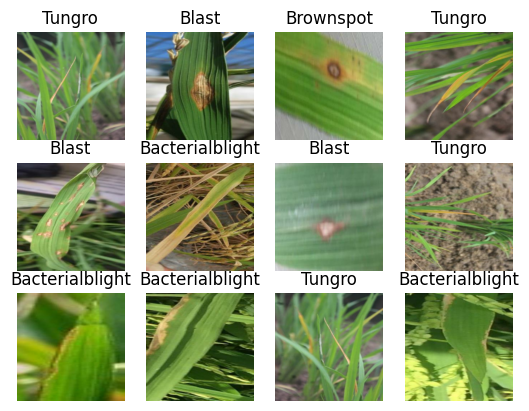

In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

186

In [8]:
train_size=0.8
len(dataset)*train_size

148.8

In [9]:
train_ds = dataset.take(148)
len(train_ds)

148

In [10]:
test_ds=dataset.skip(148)
len(test_ds)

38

In [11]:
val_size= 0.1
len(dataset)*val_size

18.6

In [12]:
val_ds=test_ds.take(18)
len(val_ds)

18

In [13]:
test_ds=test_ds.skip(18)
len(test_ds)

20

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

148
18
20


In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
   layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   layers.Rescaling(1./255),
])

In [17]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
  2/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.3594 - loss: 1.3858    

I0000 00:00:1716818567.304555      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 91s 437ms/step - accuracy: 0.3900 - loss: 1.2385 - val_accuracy: 0.6250 - val_loss: 0.8582
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.6694 - loss: 0.8139 - val_accuracy: 0.7240 - val_loss: 0.7112
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - accuracy: 0.7797 - loss: 0.5639 - val_accuracy: 0.8403 - val_loss: 0.4139
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 49s 333ms/step - accuracy: 0.8395 - loss: 0.4092 - val_accuracy: 0.8611 - val_loss: 0.3330
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - accuracy: 0.8884 - loss: 0.2866 - val_accuracy: 0.8594 - val_loss: 0.3485
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 50s 338ms/step - accuracy: 0.9228 - loss: 0.2215 - val_accuracy: 0.9757 - val_loss: 0.0993
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 49s 332ms/step - accuracy: 0.9308 - loss: 0.1793 - val_accuracy: 0.9115 - val_loss: 0.2434
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.9444 - loss: 0.1547 - val

In [22]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 1.0000 - loss: 0.0032


In [23]:
scores

[0.0026816611643880606, 1.0]

In [24]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 148}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
model.export('/kaggle/working/padipest_model')

Saved artifact at '/kaggle/working/padipest_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139110368774272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368774096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368778144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368773568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368778320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368773040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368780256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368781136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368777088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139110368783248: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
model.save('/kaggle/working/padipest_model.h5')

In [28]:
model.save('/kaggle/working/padipest_model.keras')

In [29]:
!zip -r padipest_model.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/__notebook__.ipynb (deflated 81%)
  adding: kaggle/working/padipest_model.keras (deflated 10%)
  adding: kaggle/working/padipest_model/ (stored 0%)
  adding: kaggle/working/padipest_model/saved_model.pb (deflated 87%)
  adding: kaggle/working/padipest_model/variables/ (stored 0%)
  adding: kaggle/working/padipest_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/padipest_model/variables/variables.index (deflated 69%)
  adding: kaggle/working/padipest_model/assets/ (stored 0%)
  adding: kaggle/working/padipest_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/padipest_model.h5 (deflated 10%)
